In [1]:
import scipy.sparse as spr
import sys
path2oti = '../../../build/'
sys.path.append(path2oti) # Add path to OTI library.

import pyoti.sparse as oti 
import pyoti.core   as coti
import pyoti.fem    as fem 

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

e  = oti.e
np = oti.np

import pyvista as pv
p = pv.BackgroundPlotter()
pv.set_plot_theme('document')

In [2]:
def cylinder(ri, ro, he = 1.0, element_order = 1, quads = False, 
           quad_incomplete = 1, quad_linear = 1, structured = False, save=False):
    """
    PORPUSE: Define a cylinder section mesh.
    """
    #***************************************************************************************************
    import gmsh

    gmsh.initialize()
    # gmsh.fltk.initialize()

    # Lets create a simple square element:
    model = gmsh.model
    geo   = model.geo
    option= gmsh.option

    P1 = geo.addPoint( 0.0, 0.0, 0.0, he, 1)
    P2 = geo.addPoint( 0.0,  ri, 0.0, he, 2)
    P3 = geo.addPoint(  ri, 0.0, 0.0, he, 3)
    P4 = geo.addPoint( 0.0,  ro, 0.0, he, 4)
    P5 = geo.addPoint(  ro, 0.0, 0.0, he, 5)

    C1 = geo.addCircleArc(P2,P1,P3)
    C2 = geo.addCircleArc(P5,P1,P4)
    
    geo.remove([P1])
    
    L1 = geo.addLine(P4,P2) # Left
    L2 = geo.addLine(P3,P5) # bottom

    loop1 = geo.addCurveLoop([C1,L2,C2,L1])

    surface = geo.addPlaneSurface([loop1])

    model.addPhysicalGroup( 0, [P1],        100 )
    model.addPhysicalGroup( 0, [P2],        101 )
    model.addPhysicalGroup( 0, [P3],        102 )
    model.addPhysicalGroup( 0, [P4],        103 )
    model.addPhysicalGroup( 0, [P5],        104 )

    model.addPhysicalGroup( 1, [C1],        201 )
    model.addPhysicalGroup( 1, [C2],        202 )
    model.addPhysicalGroup( 1, [L1],        203 )
    model.addPhysicalGroup( 1, [L2],        204 )

    model.addPhysicalGroup( 2, [surface],   301 )
    
    model.setPhysicalName( 0, 100, "center"  )
    model.setPhysicalName( 0, 101, "ri_left"  )
    model.setPhysicalName( 0, 102, "ri_right" )
    model.setPhysicalName( 0, 103, "ro_left"  )
    model.setPhysicalName( 0, 104, "ro_right" )

    model.setPhysicalName( 1, 201, "ri"    )
    model.setPhysicalName( 1, 202, "ro"    )
    model.setPhysicalName( 1, 203, "left"  )
    model.setPhysicalName( 1, 204, "right" )

    model.setPhysicalName( 2, 301, "domain"      )

    
    geo.synchronize()

    option.setNumber('Mesh.ElementOrder',element_order)


    # Recombine if quads are wanted.
    if quads:

        # Set body to recombine into quads.
        option.setNumber('Mesh.SecondOrderIncomplete',quad_incomplete)
        option.setNumber('Mesh.SecondOrderLinear',    quad_linear    )
        option.setNumber('Mesh.RecombineAll',         1)

    else:

        option.setNumber('Mesh.SecondOrderIncomplete',quad_incomplete)
        option.setNumber('Mesh.SecondOrderLinear',    quad_linear    )
        option.setNumber('Mesh.RecombineAll',         0)

    # end if 

    if structured:
        model.mesh.setTransfiniteSurface(surface)
    # end if 

    model.mesh.generate(2)

    if save:
        gmsh.write("cylinder.msh")
    # end if 

    Th = fem.mesh.from_gmsh(gmsh)

    gmsh.finalize()

    return Th

#-----------------------------------------------------------------------------------------------------

In [3]:
Th = cylinder(1,2,he=0.005,quads=False,save=True, structured=True)
Th

/Users/maristi7/opt/anaconda3/envs/pyoti/lib/python3.7/site-packages/numpy/ctypeslib.py:523: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)


< mesh object with 125711 nodes, 251423 elements of types ( point1, line2, tri3 ) >

In [4]:
nx = oti.zeros(Th.x.shape)
ny = oti.zeros(Th.x.shape)

els = Th.group_names['ri']['members'][0]
for j in range(els['types'].size):
    pass

In [5]:
Th.group_names['right']['members'][0]['indices'][0]

array([[   2, 1146],
       [1146, 1147],
       [1147, 1148],
       [1148, 1149],
       [1149, 1150],
       [1150, 1151],
       [1151, 1152],
       [1152, 1153],
       [1153, 1154],
       [1154, 1155],
       [1155, 1156],
       [1156, 1157],
       [1157, 1158],
       [1158, 1159],
       [1159, 1160],
       [1160, 1161],
       [1161, 1162],
       [1162, 1163],
       [1163, 1164],
       [1164, 1165],
       [1165, 1166],
       [1166, 1167],
       [1167, 1168],
       [1168, 1169],
       [1169, 1170],
       [1170, 1171],
       [1171, 1172],
       [1172, 1173],
       [1173, 1174],
       [1174, 1175],
       [1175, 1176],
       [1176, 1177],
       [1177, 1178],
       [1178, 1179],
       [1179, 1180],
       [1180, 1181],
       [1181, 1182],
       [1182, 1183],
       [1183, 1184],
       [1184, 1185],
       [1185, 1186],
       [1186, 1187],
       [1187, 1188],
       [1188, 1189],
       [1189, 1190],
       [1190, 1191],
       [1191, 1192],
       [1192,

In [6]:

grid = Th.to_pv()

p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=16,cmap='jet')


(vtkRenderingOpenGL2Python.vtkOpenGLActor)0x7f9c1b532768

In [104]:
Th.group_names.keys()

dict_keys(['center', 'ri_left', 'ri_right', 'ro_left', 'ro_right', 'ri', 'ro', 'left', 'right', 'domain'])

<IPython.core.display.Javascript object>


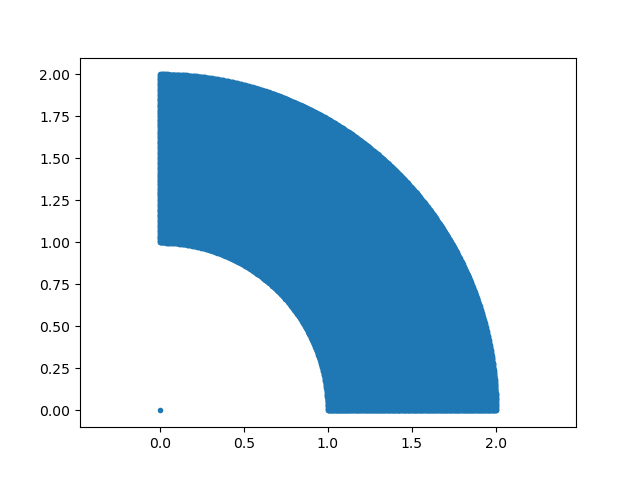

In [7]:
plt.figure()


plt.plot(Th.x.real,Th.y.real,'.')

plt.axis('equal')
plt.show()

In [8]:
# The problem to be solved:
# 
# 
Th

< mesh object with 125711 nodes, 251423 elements of types ( point1, line2, tri3 ) >

In [9]:
#*****************************************************************************************************
def solve_2d_linear_elasticity(Th, E, nu, ri, Pi, ro, Po):
    
    mu = E/(2*(1+nu))
    
    c1 = E*nu/((1+nu)*(1-2*nu))
    c2 = 2*mu
    c3 = mu
    
    ndim_analysis = 2
    els = Th.elements[2]

    fem.end_elements()
    
    nNodes = Th.x.shape[0]
    nDOF = 2*nNodes
    
    K = oti.lil_matso((nDOF,nDOF))
    f = oti.zeros((nDOF,1))
    
    K[nNodes,nNodes] = 1.0 # Removes "center" node.
    K[0,0] = 1.0 # Removes "center" node.
    
    # 
    for j in range(els['types'].size):

        elem = fem.element[ els['types'][j] ]

        if not elem.is_allocated():

            elem.end()
            elem.allocate(intorder=2)
            elem.allocate_spatial(ndim_analysis,compute_Jinv = True)

            fh = oti.zeros( ( elem.nbasis, 1 ) )

        # end if 

        elm_nodes = els['indices'][j]

        for i in range(elm_nodes.shape[0]):
            
            elems = elm_nodes[i,:]
            
            elem.set_coordinates(Th.x,Th.y,Th.z,elems)
            elem.compute_jacobian()

            Nx = elem.Nx
            Ny = elem.Ny
            N  = elem.N
            
            NxNx = oti.dot(oti.transpose(Nx),Nx)
            NyNy = oti.dot(oti.transpose(Ny),Ny)
            NyNx = oti.dot(oti.transpose(Ny),Nx)
            NxNy = oti.dot(oti.transpose(Nx),Ny)

#             problem = intV( c1*dx(vx)*dx(ux) + c1*dy(vy)*dx(ux) ) + \
#                       intV( c1*dx(vx)*dy(uy) + c1*dy(vy)*dy(uy) ) + \
#                       intV( c2*dx(vx)*dx(ux) + c2*dy(vy)*dy(uy) ) + \
#                       intV( c3*dy(vx)*dy(ux) + c3*dx(vy)*dy(ux) ) + \
#                       intV( c3*dy(vx)*dx(uy) + c3*dx(vy)*dx(uy) ) + \
#                       intS( 'in' , fxi*vx + fyi*vy ) + \
#                       intS( 'out', fxo*vx + fyo*vy ) + \
#                       on(   'left' , ux, 0.0) + \
#                       on(   'right', uy, 0.0)

#             c1*NxNx + c2*NxNx + c3*NyNy # vx, ux
#             c1*NxNy + c3*NyNx           # vx, uy
#             c1*NyNx + c3*NxNy           # vy, ux
#             c1*NyNy + c2*NyNy + c3*NxNx # vy, uy
            
            tmp11 = oti.gauss_integrate( (c1+c2)*NxNx + c3*NyNy , elem.w_dJ) # vx,ux
            tmp12 = oti.gauss_integrate(      c1*NxNy + c3*NyNx , elem.w_dJ) # vx,uy
            tmp21 = oti.gauss_integrate(      c1*NyNx + c3*NxNy , elem.w_dJ) # vy,ux
            tmp22 = oti.gauss_integrate( (c1+c2)*NyNy + c3*NxNx , elem.w_dJ) # vy,uy
            

                      
            # assemble globals
            
            for k in range(elems.size):
        
                ii=int(elems[k])
                
                i1 = ii
                i2 = ii + nNodes # Move DOF for second variable
                
                for l in range(elems.size):

                    jj=int(elems[l])
                    
                    j1 = jj
                    j2 = jj + nNodes # Move DOF for second variable
                    
                    K[i1,j1] = K[i1,j1] + tmp11[k,l]
                    
                    K[i1,j2] = K[i1,j2] + tmp12[k,l]
                    
                    K[i2,j1] = K[i2,j1] + tmp21[k,l]
                    
                    K[i2,j2] = K[i2,j2] + tmp22[k,l]

                # end for 

            # end for 
 
        # end for

    # end for

    fem.end_elements()   
    
    
    
    # 
    els = Th.group_names['ri']['members'][0]
    for j in range(els['types'].size):

        elem = fem.element[ els['types'][j] ]

        if not elem.is_allocated():

            elem.end()
            elem.allocate(intorder=2)
            elem.allocate_spatial(ndim_analysis,compute_Jinv = False)

            nxel = oti.zeros( ( elem.nbasis, 1 ) )
            xel  = oti.zeros( ( elem.nbasis, 1 ) )
            nyel = oti.zeros( ( elem.nbasis, 1 ) )
            yel  = oti.zeros( ( elem.nbasis, 1 ) )
            

        # end if 

        elm_nodes = els['indices'][j]

        for i in range(elm_nodes.shape[0]):
            
            elems = elm_nodes[i,:]
            
            elem.set_coordinates(Th.x,Th.y,Th.z,elems)
            elem.compute_jacobian()
            
            N  = oti.transpose(elem.N)  
            
            for k in range(elems.size):
                xel[k,0] = Th.x[int(elems[k]),0]
                yel[k,0] = Th.y[int(elems[k]),0]
            # end for 
            
            nxel = xel/ri
            nyel = yel/ri
            
            
            tmp1 = oti.gauss_integrate( (Pi)*oti.dot_product(nxel,N)*N, elem.w_dJ) # vx,ux
            tmp2 = oti.gauss_integrate( (Pi)*oti.dot_product(nyel,N)*N, elem.w_dJ) # vy,ux
            
            # assemble globals            
            for k in range(elems.size):
        
                ii=int(elems[k])

                i1 = ii
                i2 = ii + nNodes
                
                f[i1,0] = f[i1,0] + tmp1[k,0]
                f[i2,0] = f[i2,0] + tmp2[k,0]

                # end for 

            # end for 
 
        # end for

    # end for

    fem.end_elements()  
    
    els = Th.group_names['ro']['members'][0]
    for j in range(els['types'].size):

        elem = fem.element[ els['types'][j] ]

        if not elem.is_allocated():

            elem.end()
            elem.allocate(intorder=2)
            elem.allocate_spatial(ndim_analysis,compute_Jinv = False)

            fh = oti.zeros( ( elem.nbasis, 1 ) )

        # end if 

        elm_nodes = els['indices'][j]

        for i in range(elm_nodes.shape[0]):
            
            elems = elm_nodes[i,:]
            
            elem.set_coordinates(Th.x,Th.y,Th.z,elems)
            elem.compute_jacobian()
            
            N  = oti.transpose(elem.N)
            
            for k in range(elems.size):
                xel[k,0] = Th.x[int(elems[k]),0]
                yel[k,0] = Th.y[int(elems[k]),0]
            # end for 
            
            nxel = xel/ro
            nyel = yel/ro
            
            
            tmp1 = oti.gauss_integrate( (-Po)*oti.dot_product(nxel,N)*N, elem.w_dJ) # vx,ux
            tmp2 = oti.gauss_integrate( (-Po)*oti.dot_product(nyel,N)*N, elem.w_dJ) # vy,ux
            

            # assemble globals            
            for k in range(elems.size):
        
                ii=int(elems[k])

                i1 = ii
                i2 = ii + nNodes
                
                f[i1,0] = f[i1,0] + tmp1[k,0]
                f[i2,0] = f[i2,0] + tmp2[k,0]

                # end for 

            # end for 
 
        # end for

    # end for

    fem.end_elements()
    
    # Setting Dirichlet BCs using TGV.
    TGV = 1e30
    
    # Every 1D node has dirichlet bc = 0
    els = Th.group_names['right']['members'][0]
    for j in range(els['types'].size):

        elm_nodes = np.unique(els['indices'][j])

        for ii_ in elm_nodes:
            i1 = int(ii_) # uy
            i2 = int(ii_)+nNodes # uy

            K[i2,i2] = TGV
            f[i2,0] = 0.0
            
#             K[i1,i1] = TGV
#             f[i1,0] = 0.1*TGV
        
        # end for 
        
        
    # end for
    
    els = Th.group_names['left']['members'][0]
    for j in range(els['types'].size):

        elm_nodes = np.unique(els['indices'][j])

        for ii_ in elm_nodes:
            ii = int(ii_) # ux
            K[ii,ii] = TGV
            # end for
            f[ii,0] = 0.0
        # end for 
        
    # end for
    
    
    u = oti.solve(K.tocsr(),f)

    return u,K,f

    #-----------------------------------------------------------------------------------------------------
    
def assemble_globals(Kel,fel,Kgl,fgl,elem):
    
    
    for i in range(elem.size):
        
        ii=int(elem[i])
        
        for j in range(elem.size):

            jj=int(elem[j])
        
            Kgl[ii,jj] = Kgl[ii,jj] + Kel[i,j]
            
        # end for 
        fgl[ii,0] = fgl[ii,0] + fel[i,0]
        
    # end for 

    
def analytic_solution(Th,E,nu,ri,pi,ro,po):
    
    A = ri**2*ro**2*(po-pi)/(ro**2-ri**2)
    B = (ri**2*pi - ro**2*po)/(ro**2-ri**2)
    
    x = Th.x
    y = Th.y
    
    r =  (x**2+y**2)**0.5
    
    ur = (1+nu)*r/E*((1-2*nu)*B-A/(r**2))
    
    ux = ur*x/r
    uy = ur*y/r
    
    return ux, uy

In [10]:
Th.nodes.shape

(125711, 3)

In [17]:
u_res,K,f = solve_2d_linear_elasticity(Th,21e5,0.28,1,10,2,1000)
# print(u)
u = np.zeros((u_res.shape[0]//2,3))
u[:,0:1] = u_res.real[:u_res.shape[0]//2,:]
u[:,1:2] = u_res.real[u_res.shape[0]//2:,:]

u[0,0:2] = np.nan
u

array([[            nan,             nan,  0.00000000e+00],
       [-6.62675728e-30, -1.16125257e-03,  0.00000000e+00],
       [-1.16125250e-03, -6.62675704e-30,  0.00000000e+00],
       ...,
       [-1.04267777e-03, -3.38535944e-04,  0.00000000e+00],
       [-3.49563717e-04, -1.04824723e-03,  0.00000000e+00],
       [-1.04824717e-03, -3.49563694e-04,  0.00000000e+00]])

In [12]:
ux_a, uy_a = analytic_solution(Th,21e5,0.28,1,10,2,1000)
u_a = np.zeros_like(u)
u_a[:,0:1]=ux_a.real
u_a[:,1:2]=uy_a.real
u_a

array([[        nan,         nan,  0.        ],
       [-0.        , -0.00116126,  0.        ],
       [-0.00116126, -0.        ,  0.        ],
       ...,
       [-0.00104268, -0.00033854,  0.        ],
       [-0.00034957, -0.00104825,  0.        ],
       [-0.00104825, -0.00034957,  0.        ]])

In [13]:
import pyvista as pv
p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [u],pd_names=['u'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet', scalar_bar_args={'interactive':True})
p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [14]:
import pyvista as pv
p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [u_a],pd_names=['u_analytic'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet', scalar_bar_args={'interactive':True})
p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [16]:
import pyvista as pv
p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [u-u_a],pd_names=['absolute error'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet')#, scalar_bar_args={'interactive':True})
p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()